In [9]:
import torch
import torch.utils.data
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
GPU = torch.cuda.is_available()

In [10]:
# Grab data from csv

df = pd.read_csv('../input/aps360_airbnb1.csv', index_col=False)
df.head()

,Unnamed: 0,host_is_superhost,guests_included,bathrooms,bedrooms,beds,price,cleaning_fee,instant_bookable,ballard,beacon_hill,capitol_hill,cascade,central_area,delridge,downtown,interbay,lake_city,magnolia,northgate,other_neighborhoods,queen_anne,rainier_valley,seward_park,university_district,west_seattle,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,...,air_conditioning,breakfast,buzzer/wireless_intercom,cable_tv,carbon_monoxide_detector,cat(s),dog(s),doorman,dryer,elevator_in_building,essentials,family/kid_friendly,fire_extinguisher,first_aid_kit,free_parking_on_premises,gym,hair_dryer,hangers,heating,hot_tub,indoor_fireplace,internet,iron,kitchen,laptop_friendly_workspace,lock_on_bedroom_door,other_pet(s),pets_allowed,pets_live_on_this_property,pool,safety_card,shampoo,smoke_detector,smoking_allowed,suitable_for_events,tv,washer,washer_/_dryer,wheelchair_accessible,wireless_internet
0,0,0,0.133333,0.1250,0.142857,0.000000,0.066327,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
1,1,1,0.066667,0.1250,0.142857,0.000000,0.132653,0.133333,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1
2,2,0,0.666667,0.5625,0.714286,0.428571,0.974490,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1
3,3,0,0.066667,0.1250,0.000000,0.071429,0.081633,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1
4,4,0,0.400000,0.2500,0.428571,0.142857,0.438776,0.416667,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1


In [11]:
df_cols = list(df.columns)
df_cols.remove('price')
df_cols.remove('Unnamed: 56')
df_cols.remove('Unnamed: 0')
df_cols.append('price')
df = df[df_cols]

input_features = len(df_cols) - 1
print(input_features)
print(len(df))

95
3793


In [12]:
# turn data into 
datanp = df.values.astype(np.float32)
np.random.seed(50) # set the numpy seed for consistent split

# Data split count (train/valid/test): 2276/758/759
train_set = np.random.choice(range(3793), 2276, replace=False)
train_set.sort()
valid_set = np.random.choice([i for i in range(3793) if i not in train_set], 758, replace=False)
valid_set.sort()
test_set = [i for i in range(3793) if i not in train_set and i not in valid_set]

train_set = datanp[train_set]
valid_set = datanp[valid_set]
test_set = datanp[test_set]

separator = torch.from_numpy(np.array(range(input_features)))

In [13]:
class AirbnbPredictor(nn.Module):
    '''
    Class that holds regression model for Airbnb listing price prediction

    input : feature tensor of N x _______
    output : float value of price estimate (normalized)
    '''
    def __init__(self, N):
        super(AirbnbPredictor, self).__init__()
        self.name = 'AirbnbPredictor'
        self.features = nn.Sequential(
            nn.Linear(N, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [14]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

    Args:
        model: PyTorch neural network object
        loader: PyTorch data loader for the dataset
        criterion: The loss function

    Returns:
        acc: A scalar for the avg classification acc over the validation set
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0.0
    total_epoch = 0

    for i, data in enumerate(loader, 0):
        price = torch.index_select(data, 1, torch.LongTensor([input_features]))
        inputs = torch.index_select(data, 1, separator)
        if GPU:
            inputs = inputs.cuda()
            price = price.cuda()

        outputs = model(inputs)
        total_epoch += len(price)
        loss = criterion(outputs, price)
        total_loss += loss.item()

    loss = float(total_loss) / (i + 1)

    return loss

In [15]:
# Training code

def train_net(model, train_set, valid_set, batch_size, learning_rate, num_epochs, name='default'):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    if GPU:
        torch.cuda.manual_seed_all(1000)

    ########################################################################
    # Setup data loaders for np arrays
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
    
    print("Data loaded. Starting training:")

    ########################################################################
    # Loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    ########################################################################
    # Train the network
    for epoch in range(num_epochs):
        total_train_loss = 0.
        total_epoch = 0

        for i, data in enumerate(train_loader):
            price = torch.index_select(data, 1, torch.LongTensor([input_features]))
            inputs = torch.index_select(data, 1, separator)
            if GPU:
                inputs = inputs.cuda()
                price = price.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = model(inputs)
            loss = criterion(outputs, price)
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(outputs)
        
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(model, valid_loader, criterion)

        print(("Epoch {}: Train loss: {} | "+ "Validation loss: {}").format(epoch + 1, train_loss[epoch], val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = "MODEL{}_NAME{}_EPOCH{}".format(model.name, name, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')

    train_loss, val_loss
    plt.title("Training & Validation Loss")
    plt.plot(range(1,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

Data loaded. Starting training:
Epoch 1: Train loss: 0.1476051981250445 | Validation loss: 0.14746536314487457
Epoch 2: Train loss: 0.14435613621026278 | Validation loss: 0.14459842753907046
Epoch 3: Train loss: 0.1418600065840615 | Validation loss: 0.14201266504824162
Epoch 4: Train loss: 0.13884489548703036 | Validation loss: 0.1391142631570498
Epoch 5: Train loss: 0.13624594846947324 | Validation loss: 0.13638640691836676
Epoch 6: Train loss: 0.13362597229166162 | Validation loss: 0.13386021306117377
Epoch 7: Train loss: 0.13160294170180956 | Validation loss: 0.13092511737098297
Epoch 8: Train loss: 0.12814824810872474 | Validation loss: 0.1283129376048843
Epoch 9: Train loss: 0.1262289479167925 | Validation loss: 0.1253764107823372
Epoch 10: Train loss: 0.12353715983529885 | Validation loss: 0.12285053326437871
Epoch 11: Train loss: 0.12085728357649511 | Validation loss: 0.1203058719014128
Epoch 12: Train loss: 0.1183242846487297 | Validation loss: 0.11783825140446424
Epoch 13: Tra

Epoch 102: Train loss: 0.02226395272494604 | Validation loss: 0.021910671377554536
Epoch 103: Train loss: 0.02214000729792234 | Validation loss: 0.021659331279806793
Epoch 104: Train loss: 0.021657434835409124 | Validation loss: 0.02149431690728913
Epoch 105: Train loss: 0.021774676395580173 | Validation loss: 0.021179150518340368
Epoch 106: Train loss: 0.021392679100649223 | Validation loss: 0.020955150209677715
Epoch 107: Train loss: 0.02088010197298394 | Validation loss: 0.020775561414969463
Epoch 108: Train loss: 0.02082909353905254 | Validation loss: 0.020514809642918408
Epoch 109: Train loss: 0.02055864637562384 | Validation loss: 0.02030757733155042
Epoch 110: Train loss: 0.02055438059485621 | Validation loss: 0.02028988309515019
Epoch 111: Train loss: 0.020017686759173457 | Validation loss: 0.01992997988903274
Epoch 112: Train loss: 0.019902172847650945 | Validation loss: 0.01984221503759424
Epoch 113: Train loss: 0.019689124763115413 | Validation loss: 0.019575161626562476
Epo

Epoch 201: Train loss: 0.012960571123080121 | Validation loss: 0.012706446112133563
Epoch 202: Train loss: 0.012912039936054498 | Validation loss: 0.012451335128086308
Epoch 203: Train loss: 0.012939340713071741 | Validation loss: 0.012413781136274338
Epoch 204: Train loss: 0.01285830547567457 | Validation loss: 0.0123900943241703
Epoch 205: Train loss: 0.012762955519267254 | Validation loss: 0.01244835346005857
Epoch 206: Train loss: 0.012743817118462175 | Validation loss: 0.012336235978485396
Epoch 207: Train loss: 0.012710698149425702 | Validation loss: 0.012399984193810573
Epoch 208: Train loss: 0.012619764249797704 | Validation loss: 0.01233724165164555
Epoch 209: Train loss: 0.012920275653919412 | Validation loss: 0.012226896593347192
Epoch 210: Train loss: 0.012709605565760285 | Validation loss: 0.012317976468087485
Epoch 211: Train loss: 0.012681924039497972 | Validation loss: 0.012255945960835865
Epoch 212: Train loss: 0.012550936662591994 | Validation loss: 0.0122397228454550

Epoch 300: Train loss: 0.011654238404136978 | Validation loss: 0.010874458491646996
Epoch 301: Train loss: 0.011399934158867432 | Validation loss: 0.010883939103223383
Epoch 302: Train loss: 0.011366187743583901 | Validation loss: 0.010842979691612223
Epoch 303: Train loss: 0.011727880783534298 | Validation loss: 0.01087866370410969
Epoch 304: Train loss: 0.011423090576297708 | Validation loss: 0.01089327516577517
Epoch 305: Train loss: 0.01130991529013651 | Validation loss: 0.010903599963057786
Epoch 306: Train loss: 0.011475501633766625 | Validation loss: 0.010831811639945954
Epoch 307: Train loss: 0.01132834058888774 | Validation loss: 0.010949082594985763
Epoch 308: Train loss: 0.011379193870298978 | Validation loss: 0.010923769402628144
Epoch 309: Train loss: 0.01139364275150001 | Validation loss: 0.01086387992836535
Epoch 310: Train loss: 0.011312945642405085 | Validation loss: 0.010804950667079538
Epoch 311: Train loss: 0.011373413176948411 | Validation loss: 0.01084243925288319

Epoch 399: Train loss: 0.010983051887402931 | Validation loss: 0.010450979384283224
Epoch 400: Train loss: 0.010917288024858054 | Validation loss: 0.010407269738304118
Epoch 401: Train loss: 0.010928850908789577 | Validation loss: 0.010449400870129466
Epoch 402: Train loss: 0.010946608876110986 | Validation loss: 0.010477706848178059
Epoch 403: Train loss: 0.010922935445301441 | Validation loss: 0.010376180541546395
Epoch 404: Train loss: 0.010968350252369419 | Validation loss: 0.010410196671728045
Epoch 405: Train loss: 0.010910609368390093 | Validation loss: 0.010378393480399003
Epoch 406: Train loss: 0.01092776201484311 | Validation loss: 0.010396656483256569
Epoch 407: Train loss: 0.01091403934212091 | Validation loss: 0.010402441315818578
Epoch 408: Train loss: 0.0109701174725261 | Validation loss: 0.010394390788860619
Epoch 409: Train loss: 0.011216535485194376 | Validation loss: 0.01045945956138894
Epoch 410: Train loss: 0.011070002261678584 | Validation loss: 0.0103495048048595

Epoch 500: Train loss: 0.010999217302823026 | Validation loss: 0.010243952293725064
Epoch 501: Train loss: 0.010687758335229268 | Validation loss: 0.010196380026172847
Epoch 502: Train loss: 0.010701614008414455 | Validation loss: 0.010143887212810418
Epoch 503: Train loss: 0.010696822599533739 | Validation loss: 0.010142810322577134
Epoch 504: Train loss: 0.010716095896592984 | Validation loss: 0.010110241467676436
Epoch 505: Train loss: 0.010693122872099694 | Validation loss: 0.010140994389075786
Epoch 506: Train loss: 0.010760100642477887 | Validation loss: 0.010096319757091502
Epoch 507: Train loss: 0.010744834959041327 | Validation loss: 0.010399248140553633
Epoch 508: Train loss: 0.010708679584139544 | Validation loss: 0.010132400260772556
Epoch 509: Train loss: 0.010678877908503637 | Validation loss: 0.010136080449835086
Epoch 510: Train loss: 0.011182120053692617 | Validation loss: 0.010095301375258714
Epoch 511: Train loss: 0.01086667461721744 | Validation loss: 0.010187371187

Epoch 599: Train loss: 0.010584407288762223 | Validation loss: 0.010154229608209183
Epoch 600: Train loss: 0.010559081599543182 | Validation loss: 0.01000789160025306
Epoch 601: Train loss: 0.010603974469833903 | Validation loss: 0.009984966115249941
Epoch 602: Train loss: 0.010586323633712405 | Validation loss: 0.010036371784129491
Epoch 603: Train loss: 0.010709331729837382 | Validation loss: 0.010040098471411815
Epoch 604: Train loss: 0.010551241342909634 | Validation loss: 0.01002234853998137
Epoch 605: Train loss: 0.010550376509652577 | Validation loss: 0.010075914285456141
Epoch 606: Train loss: 0.010588315134454105 | Validation loss: 0.010102182743139565
Epoch 607: Train loss: 0.010546349910631156 | Validation loss: 0.00996001282085975
Epoch 608: Train loss: 0.010663640588366738 | Validation loss: 0.009972963947802782
Epoch 609: Train loss: 0.010566842512667386 | Validation loss: 0.009961126566243669
Epoch 610: Train loss: 0.010684534907341003 | Validation loss: 0.01006311292682

Epoch 698: Train loss: 0.010503241979879223 | Validation loss: 0.009929564703876773
Epoch 699: Train loss: 0.010529408179637458 | Validation loss: 0.009829248941969126
Epoch 700: Train loss: 0.010466777929751616 | Validation loss: 0.009829049289692193
Epoch 701: Train loss: 0.010469900673746856 | Validation loss: 0.009942166099790484
Epoch 702: Train loss: 0.010458675255196996 | Validation loss: 0.009847428785481801
Epoch 703: Train loss: 0.010427079270205772 | Validation loss: 0.009836540285808345
Epoch 704: Train loss: 0.010451393428310338 | Validation loss: 0.009919666044879705
Epoch 705: Train loss: 0.01045754945759351 | Validation loss: 0.009941020844659457
Epoch 706: Train loss: 0.010456304133792097 | Validation loss: 0.01009776503390943
Epoch 707: Train loss: 0.010426614764987284 | Validation loss: 0.010168988063621024
Epoch 708: Train loss: 0.010551027669053938 | Validation loss: 0.009849120629951358
Epoch 709: Train loss: 0.010461148443735309 | Validation loss: 0.0099132890657

Epoch 797: Train loss: 0.010422348698031984 | Validation loss: 0.009718070340265209
Epoch 798: Train loss: 0.010381234602795707 | Validation loss: 0.009990701869052524
Epoch 799: Train loss: 0.010381650551506836 | Validation loss: 0.009790731011889875
Epoch 800: Train loss: 0.010320318431089012 | Validation loss: 0.009792836441192776
Epoch 801: Train loss: 0.01038067296354307 | Validation loss: 0.009786122672570249
Epoch 802: Train loss: 0.010472437961854868 | Validation loss: 0.009753886901307851
Epoch 803: Train loss: 0.010395544380622191 | Validation loss: 0.009716794680571184
Epoch 804: Train loss: 0.010365844290289614 | Validation loss: 0.009737365772404397
Epoch 805: Train loss: 0.010410352383688506 | Validation loss: 0.009707458521006629
Epoch 806: Train loss: 0.010365238254760496 | Validation loss: 0.009786519435389588
Epoch 807: Train loss: 0.010361824453058135 | Validation loss: 0.00978001362333695
Epoch 808: Train loss: 0.01032776079308759 | Validation loss: 0.00969126571241

Epoch 896: Train loss: 0.010235579676292319 | Validation loss: 0.009641818255962184
Epoch 897: Train loss: 0.010230623489607953 | Validation loss: 0.009617473251031091
Epoch 898: Train loss: 0.010411088345184302 | Validation loss: 0.009742413007188588
Epoch 899: Train loss: 0.010226366407651868 | Validation loss: 0.009945057720566789
Epoch 900: Train loss: 0.010215860937023535 | Validation loss: 0.009617733652703464
Epoch 901: Train loss: 0.010255478710557023 | Validation loss: 0.009655138341865191
Epoch 902: Train loss: 0.010216783832422353 | Validation loss: 0.00960400050583606
Epoch 903: Train loss: 0.010242134238877851 | Validation loss: 0.009698089823359624
Epoch 904: Train loss: 0.0102841641217108 | Validation loss: 0.00963337040351083
Epoch 905: Train loss: 0.010202347834516937 | Validation loss: 0.009575720663027218
Epoch 906: Train loss: 0.01021870181365456 | Validation loss: 0.009627893955136338
Epoch 907: Train loss: 0.010227553656376485 | Validation loss: 0.0096613995071190

Epoch 995: Train loss: 0.010142405173003985 | Validation loss: 0.009478694526478648
Epoch 996: Train loss: 0.010138451464525942 | Validation loss: 0.009617242690486213
Epoch 997: Train loss: 0.010174522215190033 | Validation loss: 0.009494140608391414
Epoch 998: Train loss: 0.01010907660060588 | Validation loss: 0.009719558292999864
Epoch 999: Train loss: 0.010303899571428903 | Validation loss: 0.009496528936627632
Epoch 1000: Train loss: 0.010173246439080685 | Validation loss: 0.009599401072288552
Finished Training


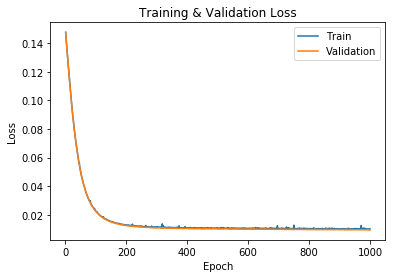

In [16]:
test_model = AirbnbPredictor(input_features) if not GPU else AirbnbPredictor(input_features).cuda()
train_net(test_model, train_set, valid_set, batch_size=32, learning_rate=3e-4, num_epochs=1000, name='default')

In [17]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=0)
evaluate(test_model, test_loader, torch.nn.MSELoss())

0.010839870306275165